# DS 4400 Final Project : Credit Card Fraud Detection

#### Emily Chen, Glen Damian Lim, Tara Sawhney

#### Dataset : https://www.kaggle.com/datasets/kartik2112/fraud-detection

#### ML models: Logistic Regression, Decision Trees, Feedforward Neural Networks, Recurrent Neural Networks

In [2]:
import os 
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML libraries
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
import segmentation_models as sm
# Neural Networks libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.optimizers import SGD, Adam
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
sns.set(rc = {'figure.figsize':(20,10)})
fraud_df = pd.read_csv('data/fraudTrain.csv')
fraud_df.drop_duplicates(inplace=True)

## Data Analysis

In [4]:
fraud_df['amt'].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [5]:
np.percentile(fraud_df['amt'],99)

545.9926000000002

#### Transaction Amount vs Fraud

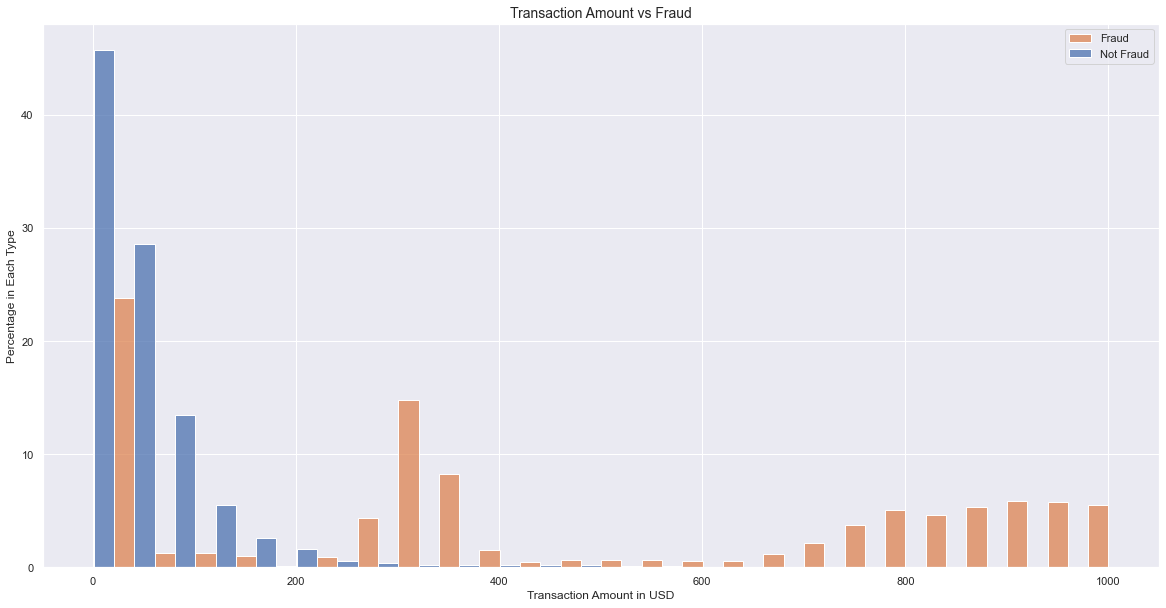

In [6]:
# amount vs fraud

# Plotting a histogram of transaction amount vs fraud
# Filtering the data to only include transactions with amount less than or equal to 1000
# Specifying 'is_fraud' column as hue to differentiate between fraudulent and non-fraudulent transactions
# Using 'percent' as the statistic to show the percentage of transactions in each category
# Specifying 'dodge' as the multiple parameter to show the histograms side-by-side
# Turning off the common normalization to display the raw counts
# Using 25 bins to display the data more clearly
ax=sns.histplot(x='amt',data=fraud_df[fraud_df['amt']<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_title('Transaction Amount vs Fraud', fontsize=14)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(labels=['Fraud', 'Not Fraud'])

While normal transactions tend to be around 200 or less, fraud transactions are typically peak around 300 as well as 800-1000

#### Gender vs Fraud

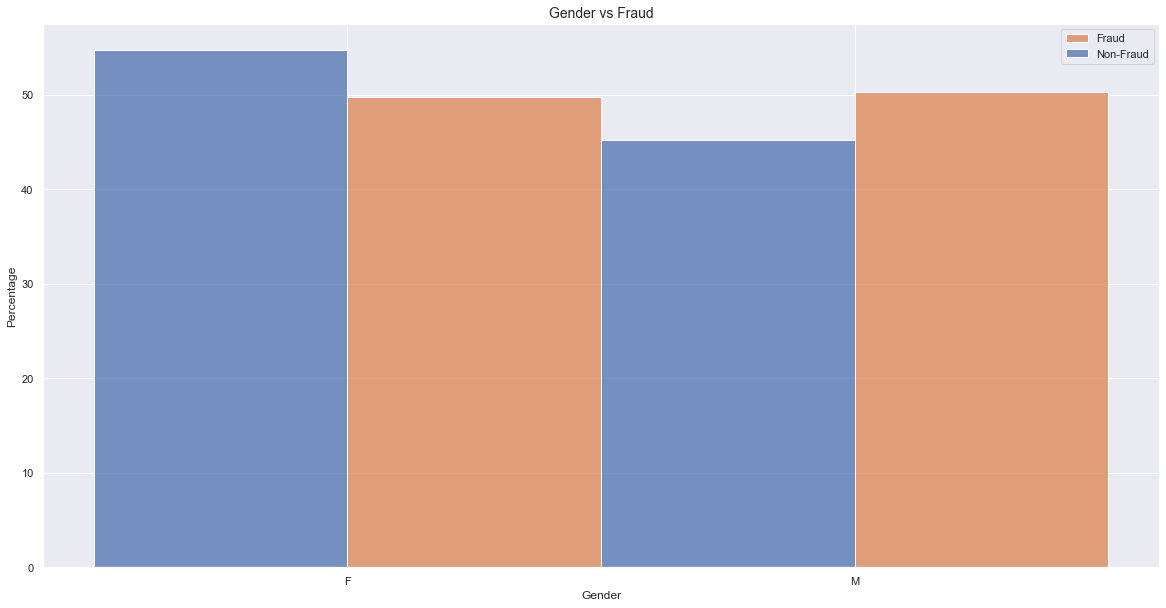

In [7]:
#plot gender vs fraud 

# Plotting a histogram of gender vs fraud
# Specifying the 'gender' column as the x-axis and the 'is_fraud' column as the hue to differentiate between fraudulent and non-fraudulent transactions
# Using 'percent' as the statistic to show the percentage of transactions in each category
# Specifying 'dodge' as the multiple parameter to show the histograms side-by-side
# Turning off the common normalization to display the raw counts
ax = sns.histplot(x=fraud_df['gender'], data=fraud_df, hue=fraud_df['is_fraud'], 
                  stat='percent', multiple='dodge', common_norm=False)

ax.set_title("Gender vs Fraud", fontsize=14)
ax.set_xlabel("Gender")
ax.set_ylabel("Percentage")

plt.legend(labels=['Fraud', 'Non-Fraud'])

There is no clear difference between genders when it comes to fraud vs non-fraud transactions. According to the figure about, both males and females are equally prone to fraud transaction and gender is not an indicative amount of fraud transaction. 

#### Spending Category vs Fraud

Text(0.5, 1.0, 'Percent Difference of Fraudulent over Non-Fraudulent Transactions in Each Spending Category')

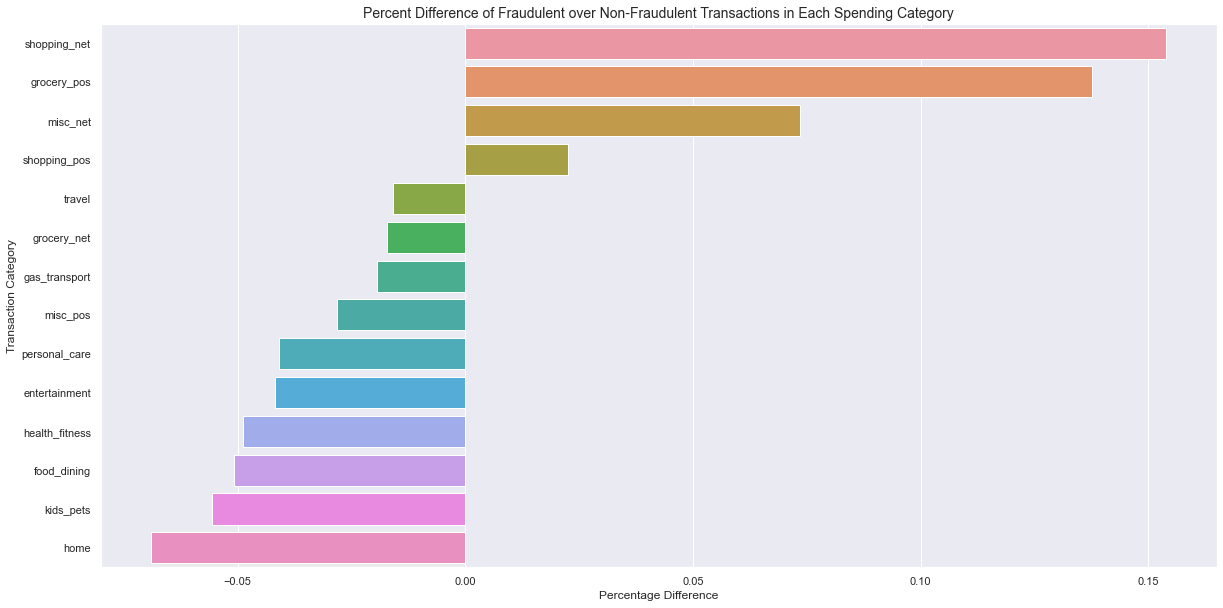

In [8]:
#calculating the percentage difference between fraudulent and non-fraudulent transactions in each spending category
#filtering the data to only include non-fraudulent transactions, then counting the percentage of transactions in each spending category
spending_cat_1 = fraud_df[fraud_df['is_fraud'] == 0]['category'].value_counts(normalize=True).to_frame().reset_index()
spending_cat_1.columns = ['Category', 'Non-Fraud Percentage']

#filtering the data to only include fraudulent transactions, then counting the percentage of transactions in each spending category
spending_cat_2 = fraud_df[fraud_df['is_fraud'] == 1]['category'].value_counts(normalize=True).to_frame().reset_index()
spending_cat_2.columns = ['Category', 'Fraud Percentage']

#merging the two dataframes on the 'Category' column
merge = spending_cat_1.merge(spending_cat_2, on='Category')

#adding a column to the merged dataframe that calculates the percentage difference between the fraudulent and non-fraudulent transactions in each spending category
merge['diff'] = merge['Fraud Percentage'] - merge['Non-Fraud Percentage']

#plotting a bar chart of the percentage difference of fraudulent over non-fraudulent transactions in each spending category
#sorting the data by the 'diff' column in descending order
fig = sns.barplot(y='Category', x='diff', data=merge.sort_values('diff', ascending=False))

#adding labels to the plot
fig.set_xlabel('Percentage Difference')
fig.set_ylabel('Transaction Category')
plt.title('Percent Difference of Fraudulent over Non-Fraudulent Transactions in Each Spending Category', fontsize=14)


Some categories have more fraudulent transactions than others. These tend to be Shopping, Groceries, and Miscellaneous. Home, Kids/Pets tend to have more normal transactions.

#### Age vs Fraud

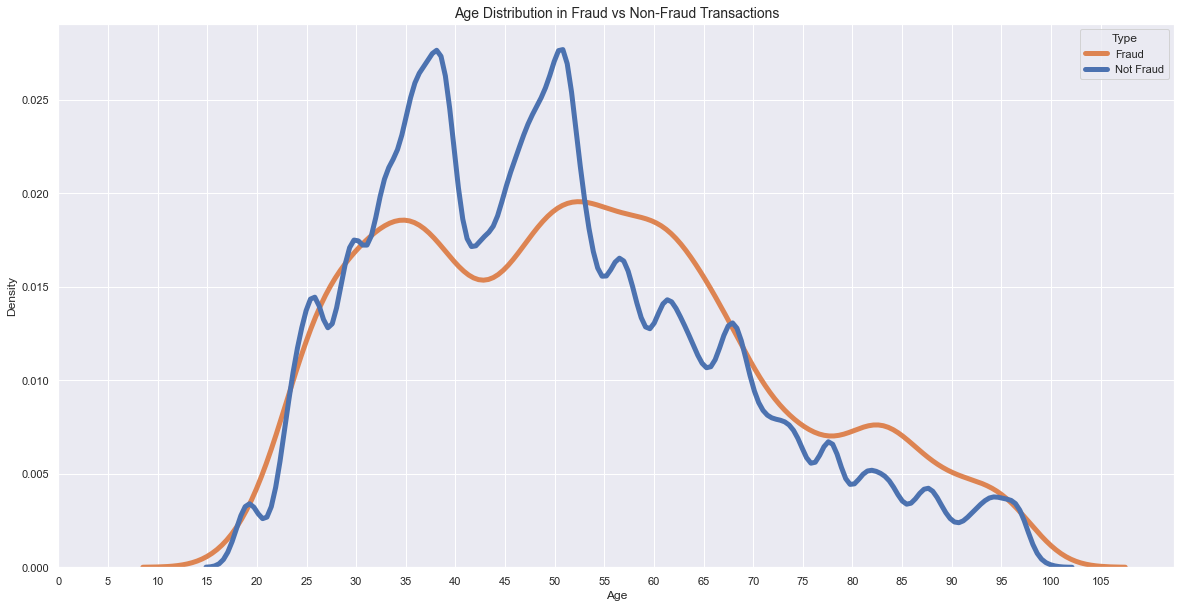

In [11]:
#calculating the age of each customer by subtracting their year of birth from the current year
fraud_df['age'] = dt.date.today().year - pd.to_datetime(fraud_df['dob']).dt.year

#plotting a kernel density estimate (KDE) plot of the age distribution of fraudulent and non-fraudulent transactions
#using 'age' as the x-axis and the 'is_fraud' column as the hue to differentiate between fraudulent and non-fraudulent transactions
#setting 'linewidth' to 5 for a thicker line
#turning off the common normalization to display the raw counts
fig = sns.kdeplot(x=fraud_df['age'], data=fraud_df, hue=fraud_df['is_fraud'], linewidth=5, common_norm=False)

#adding labels to the plot
fig.set_xlabel('Age')
fig.set_ylabel('Density')

#setting the x-axis tick marks to show every 5 years
plt.xticks(np.arange(0, 110, 5))

#adding a title and legend to the plot
plt.title('Age Distribution in Fraud vs Non-Fraud Transactions', fontsize=14)
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])


According to the figure above, normal transactions are highest at ages 37-38 and 49-50, whereas fraud transactions are smoother, second peak includes a bigger group (ages 50-65). This indicated that older people are more likely to be subject to fraud transactions than younger people. 

In [12]:
#constructing the age-transaction count distribution
age = fraud_df[['age','trans_num']].groupby(['age']).count().reset_index()
age.columns = ['age', 'age_count']

#creating the age-fraud distribution
fraud_age = fraud_df[['age', 'trans_num', 'is_fraud']].groupby(['age','is_fraud']).count().reset_index()
fraud_age.columns = ['age', 'is_fraud', 'Transaction Count']

fraud_age = fraud_age.merge(age[['age', 'age_count']], how='inner', on='age')

fraud_age['Transaction percentage'] = (fraud_age['Transaction Count']/fraud_age['age_count'])*100

fraud_age

,age,is_fraud,Transaction Count,age_count,Transaction percentage
0,18,0,1952,1959,99.642675
1,18,1,7,1959,0.357325
2,19,0,7464,7496,99.573106
3,19,1,32,7496,0.426894
4,20,0,3954,3975,99.471698
...,...,...,...,...,...
155,96,1,47,4645,1.011841
156,97,0,6038,6063,99.587663
157,97,1,25,6063,0.412337
158,98,1,11,11,100.000000


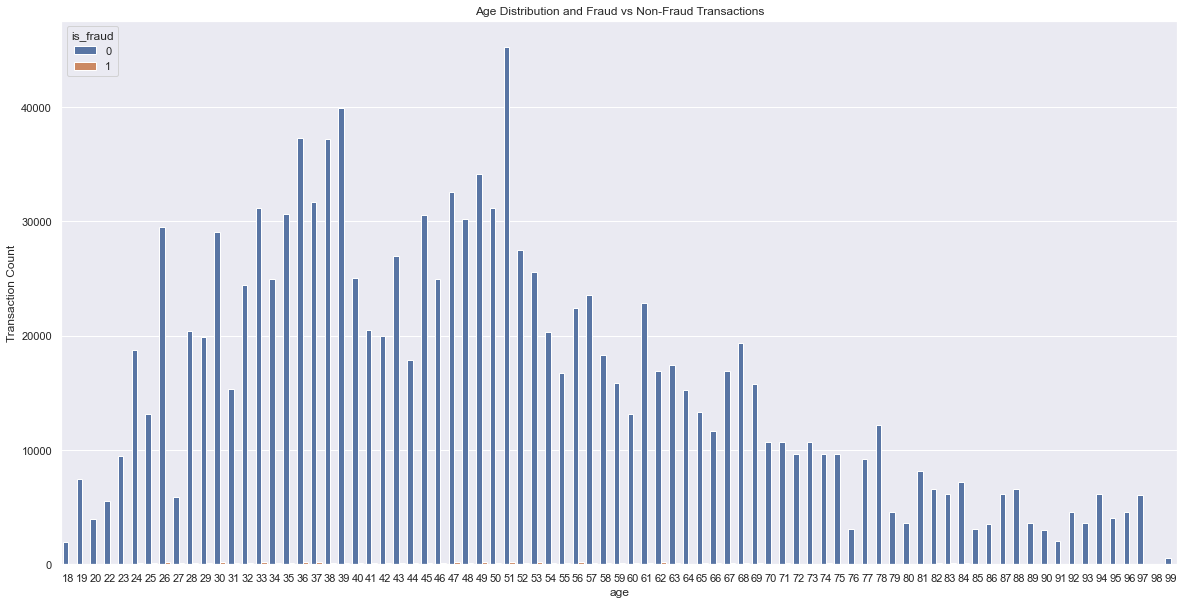

In [13]:
# This is a bar chart that depicts the same information as the line chart above, however this just shows the entire age distribution. 

sns.barplot(data=fraud_age, y='Transaction Count', x='age', hue='is_fraud')
plt.title('Age Distribution and Fraud vs Non-Fraud Transactions')
plt.show()

#### Time vs Fraud

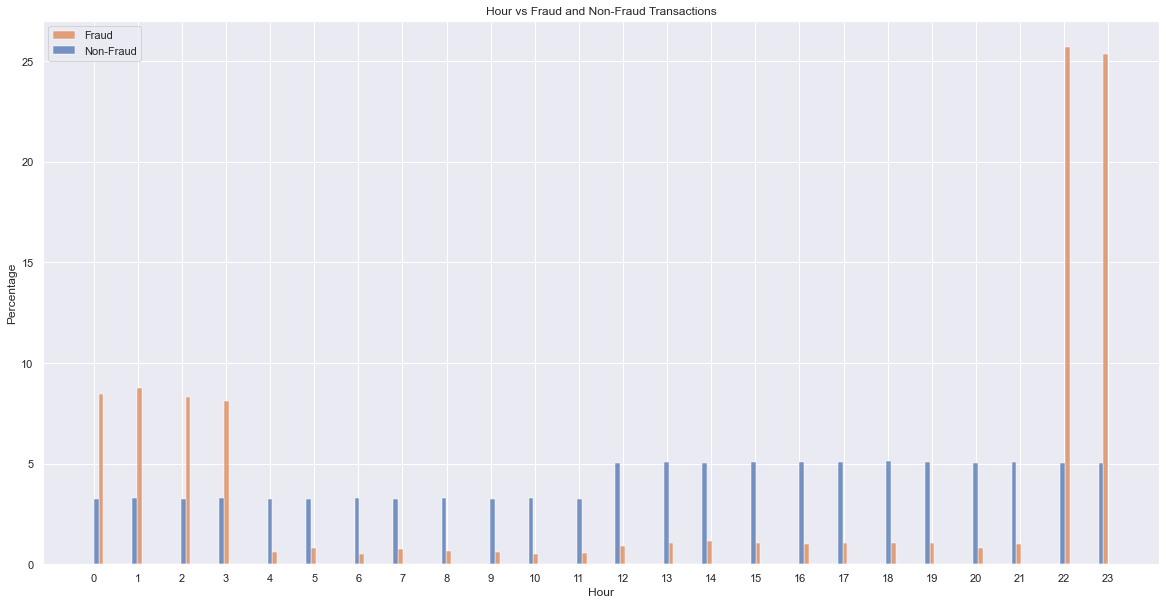

In [14]:
#HOURLY 
#extracting the hour component from the transaction timestamp
fraud_df['hour'] = pd.to_datetime(fraud_df['trans_date_trans_time']).dt.hour

#plotting a histogram of the hourly distribution of fraudulent and non-fraudulent transactions
#using 'hour' as the x-axis and the 'is_fraud' column as the hue to differentiate between fraudulent and non-fraudulent transactions
#setting 'common_norm' to False to display the raw counts
#setting 'stat' to 'percent' to display the percentage of transactions for each hour
#setting 'multiple' to 'dodge' to show the two bars side-by-side
fig = sns.histplot(data=fraud_df, x=fraud_df['hour'], hue=fraud_df['is_fraud'], common_norm=False, 
                   stat='percent', multiple='dodge')

#adding labels to the plot
fig.set_xlabel('Hour')
fig.set_ylabel('Percentage')
plt.title('Hour vs Fraud and Non-Fraud Transactions')

#setting the x-axis tick marks to show every hour
plt.xticks(np.arange(0, 24, 1))

#adding a legend to the plot
plt.legend(labels=['Fraud', 'Non-Fraud'])


/var/folders/19/j39j68y12fb87c4ngr_0z9vr0000gn/T/ipykernel_56221/4168256504.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


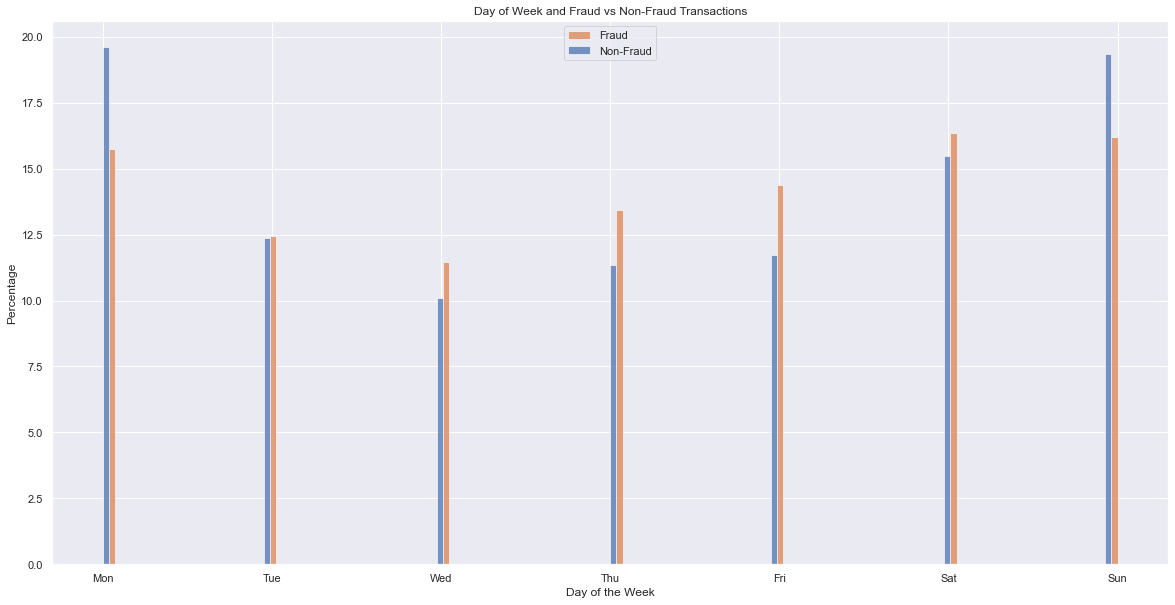

In [15]:
### WEEKLY 
fraud_df['day'] = pd.to_datetime(fraud_df['trans_date_trans_time']).dt.dayofweek

fig = sns.histplot(data=fraud_df, x=fraud_df['day'], hue=fraud_df['is_fraud'], common_norm=False, stat='percent', multiple='dodge')

fig.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

fig.set_xlabel('Day of the Week')
fig.set_ylabel('Percentage')

plt.title('Day of Week and Fraud vs Non-Fraud Transactions')
plt.legend(labels=['Fraud', 'Non-Fraud'])

/var/folders/19/j39j68y12fb87c4ngr_0z9vr0000gn/T/ipykernel_56221/2188959031.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])


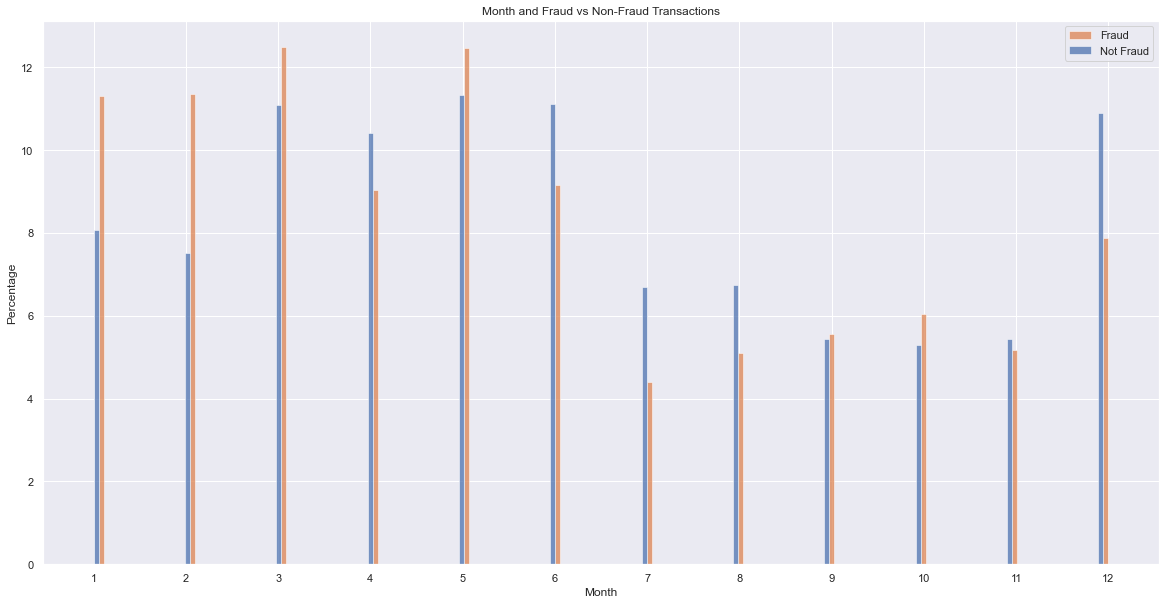

In [16]:
## MONTHLY 
#month vs fraud
fraud_df['month']=pd.to_datetime(fraud_df['trans_date_trans_time']).dt.month
fig=sns.histplot(data=fraud_df, x=fraud_df["month"], hue=fraud_df["is_fraud"], common_norm=False,stat='percent',multiple='dodge')
fig.set_xlabel('Month')
fig.set_ylabel('Percentage')
plt.title('Month and Fraud vs Non-Fraud Transactions')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(labels=['Fraud', 'Not Fraud'])

Normal payments are highest around holiday season (December) and sprign/summer, whereas fraud transactions are more concentrated in Jan-May

#### State vs Fraud 

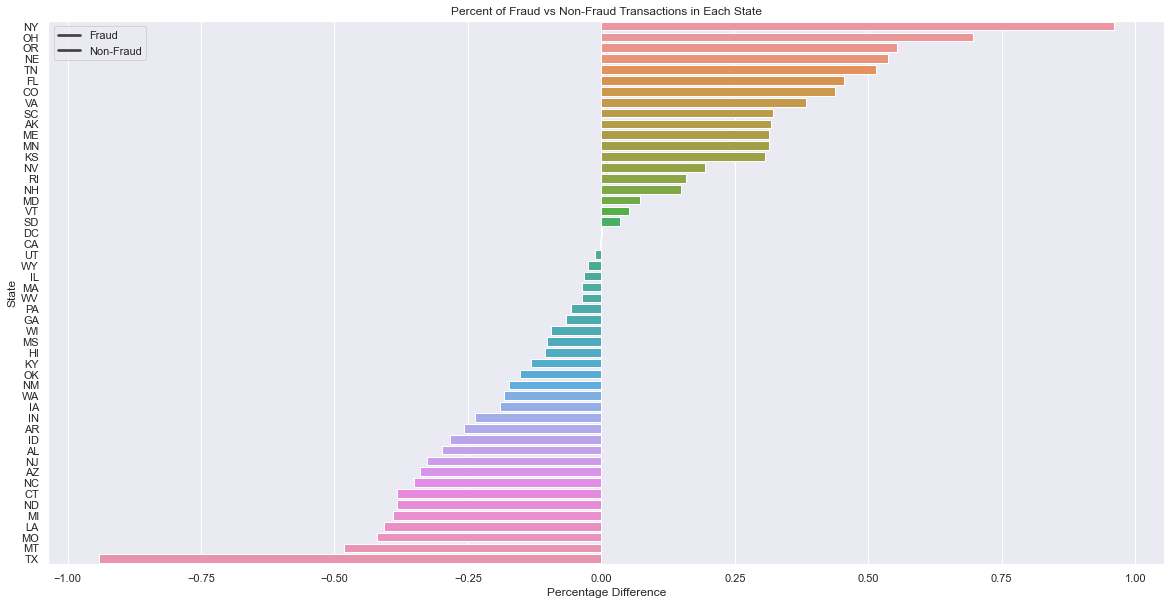

In [17]:
#calculate the percentage difference of fraudulent vs non-fraudulent transactions in each state
state_1=fraud_df['state'][fraud_df.is_fraud==0].value_counts(normalize=True)
state_1=state_1.to_frame()
state_1=state_1.reset_index()
state_1.columns = ['State', 'Percentage']

state_2=fraud_df['state'][fraud_df.is_fraud==1].value_counts(normalize=True)
state_2=state_2.to_frame()
state_2=state_2.reset_index()
state_2.columns = ['State', 'Percentage']

merge_cols=state_1.merge(state_2,on='State')
merge_cols['diff']=merge_cols['Percentage_y']-merge_cols['Percentage_x']
merge_cols['diff']=merge_cols['diff']*100
merge_cols=merge_cols.sort_values('diff',ascending=False)

#creat bar chart depicting state transactions
fig = sns.barplot(data=merge_cols, x='diff', y='State')
fig.set_xlabel('Percentage Difference')
fig.set_ylabel('State')
plt.title('Percent of Fraud vs Non-Fraud Transactions in Each State')
plt.legend(labels=['Fraud', 'Non-Fraud'])
plt.show()

As can be seen, NY and OH  higher percentage of fraudulent transactions than normal ones, while TX and MT are the opposite. However, it should be pointed out that the percentage differences in those states are not very significant but a correlation does exist.

#### Job vs Fraud

['Film/video editor', 'Exhibition designer', 'Naval architect', 'Surveyor, land/geomatics', 'Materials engineer', 'Designer, ceramics/pottery', 'Systems developer', 'IT trainer', 'Financial adviser', 'Environmental consultant', 'Chartered public finance accountant', 'Scientist, audiological', 'Chief Executive Officer', 'Copywriter, advertising', 'Comptroller', 'Sub', 'Podiatrist', 'Agricultural consultant', 'Paramedic', 'Magazine features editor']


/Users/emilychen/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


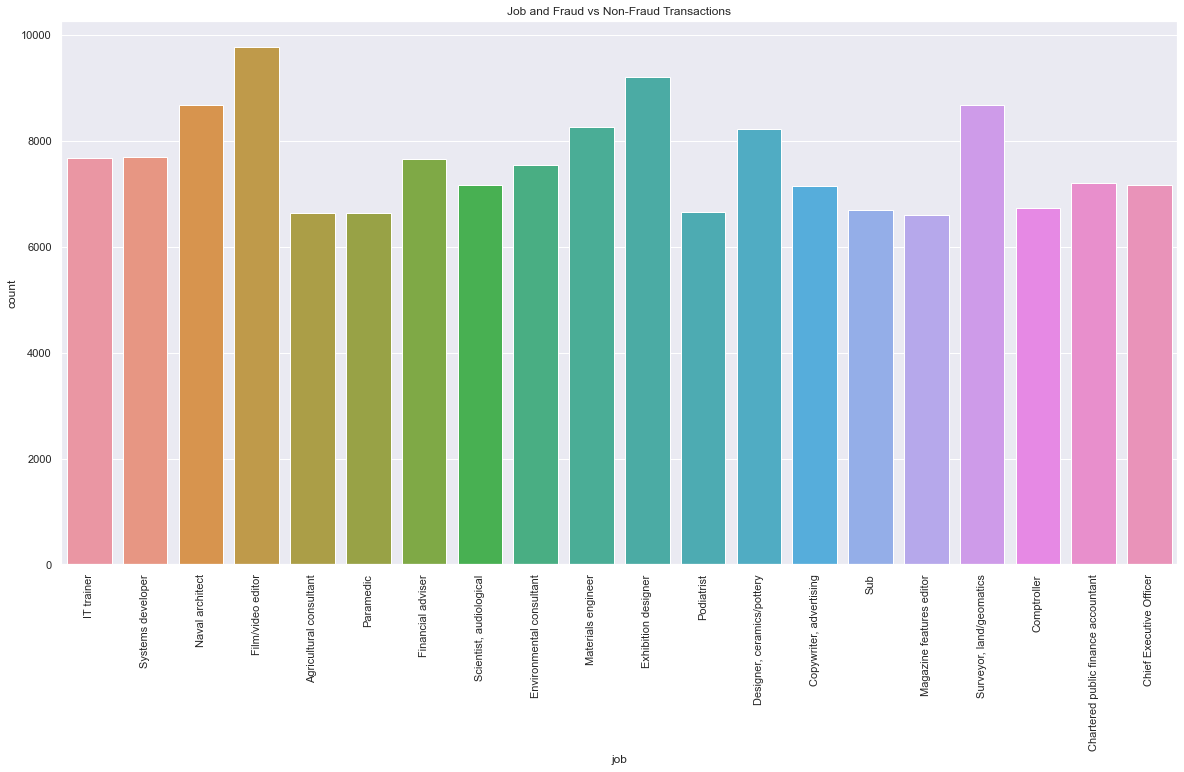

In [18]:
#fetching top 20 jobs with high transaction frequencies
high_trans_jobs = fraud_df['job'].value_counts().head(20).index.tolist()
print(high_trans_jobs)
job_plot = sns.countplot(fraud_df[fraud_df['job'].isin(high_trans_jobs)].job)
job_plot.set_xticklabels(job_plot.get_xticklabels(), rotation=90)
plt.title("Job and Fraud vs Non-Fraud Transactions")
plt.show()

In [19]:
#constructing the zip-transaction count distribution
job = fraud_df[['job','trans_num']].groupby(['job']).count().reset_index()
job.columns = ['job', 'job_count']

#creating the zip-fraud distribution
fraud_job = fraud_df[['job', 'trans_num', 'is_fraud']].groupby(['job','is_fraud']).count().reset_index()
fraud_job.columns = ['job', 'is_fraud', 'Transaction count']

fraud_job = fraud_job.merge(job[['job', 'job_count']], how='inner', on='job')

fraud_job['Transaction percentage'] = (fraud_job['Transaction count']/fraud_job['job_count'])*100

#viewing the top 30 jobs with high fraudulent transaction volumes
fraud_job[fraud_job['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(30)

,job,is_fraud,Transaction count,job_count,Transaction percentage
64,Armed forces technical officer,1,8,8,100.000000
318,"Engineer, site",1,12,12,100.000000
453,Information officer,1,8,8,100.000000
493,Legal secretary,1,12,12,100.000000
450,Industrial buyer,1,10,10,100.000000
111,Careers adviser,1,15,15,100.000000
421,Homeopath,1,11,11,100.000000
94,Broadcast journalist,1,9,9,100.000000
619,Personnel officer,1,12,12,100.000000
374,Forest/woodland manager,1,9,9,100.000000


/Users/emilychen/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


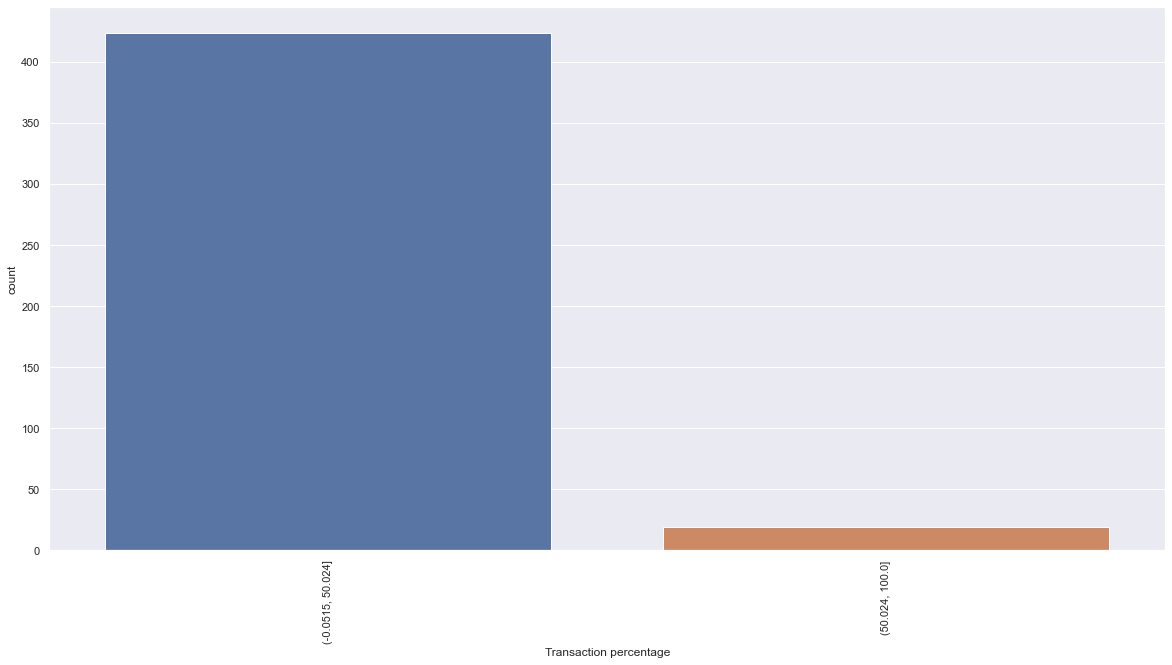

In [20]:
#plotting the fraudulent transactions percentage by binning
job_plot = sns.countplot(pd.cut(fraud_job[fraud_job.is_fraud == 1]['Transaction percentage'], bins = 2))
job_plot.set_xticklabels(job_plot.get_xticklabels(), rotation = 90)
plt.show()

In [21]:
#job with more than one percent fraudulent transactions
fraud_job.loc[(fraud_job.is_fraud == 1) & (fraud_job['Transaction percentage'] >= 50)].job

2                  Accountant, chartered
39                Air traffic controller
64        Armed forces technical officer
94                  Broadcast journalist
111                      Careers adviser
198           Contracting civil engineer
218                               Dancer
318                       Engineer, site
374              Forest/woodland manager
421                            Homeopath
450                     Industrial buyer
453                  Information officer
493                      Legal secretary
619                    Personnel officer
758    Sales promotion account executive
787                          Ship broker
795                            Solicitor
898                   Veterinary surgeon
906                    Warehouse manager
Name: job, dtype: object

The above are the jobs where in high transaction frequencies have been noted.
In the above dataframe, the transactions containing the job feature value as-Armed forces technical officer; Engineer, site; Information officer; Legal secretary; Industrial buyer; Careers adviser; Homeopath; Broadcast journalist; Personnel officer; Forest/woodland manager; Sales promotion account executive; Air traffic controller; Contracting civil engineer; Ship broker; Solicitor;2 Accountant, chartered; Dancer; Warehouse manager; Veterinary surgeon have completely fraudulent transactions

The people in the jobs with high number of fraudulent transactions can be alerted about the credit card transaction frauds so that they can be more carefull while using their credit cards.
the jobs roles in which almost all transactions are fraudulent might mean that there is some fault with the datapoint. That is, the person representing the specific job might be at fault since it is highly unlikely that all the transactions made by a person from a spceific job are fraudulent. Hence, doing some kind of background check upon the credit card user might help in this case.

## Data Pre-Processing

In [4]:
df_train = pd.read_csv('fraudTrain.csv')
df_test = pd.read_csv('fraudTest.csv')

def datetime_column(df, col_name: str, hour: bool =False, new_col_prefix: str =''):
    df[col_name] = pd.to_datetime(df[col_name])

    if hour:
        new_col = new_col_prefix + '_hour'
        df[new_col] = df[col_name].dt.hour
    df[new_col_prefix + '_weekday'] = df[col_name].dt.weekday
    df[new_col_prefix + '_month'] = df[col_name].dt.strftime("%m")
    df[new_col_prefix + '_year'] = df[col_name].dt.year

# deriving additonal columns from 'trans_date_trans_time' and 'dob' columns
datetime_column(df_train, 'trans_date_trans_time', True, 'trans')
datetime_column(df_test, 'trans_date_trans_time', True, 'trans')
datetime_column(df_train, 'dob', new_col_prefix='dob')
datetime_column(df_test, 'dob', new_col_prefix='dob')


# dropping irrelevant columns
df_train.drop(['gender','city','state','job','unix_time','Unnamed: 0','cc_num','merchant', 'first', 'last','street','zip', 'dob', 'trans_num', 'trans_date_trans_time'], axis=1, inplace=True)
df_test.drop(['gender','city','state','job','unix_time','Unnamed: 0','cc_num','merchant', 'first', 'last','street','zip', 'dob', 'trans_num', 'trans_date_trans_time'], axis=1, inplace=True)

# Convert categorical columns
categorical_column_names = ['category']
for cat_name in categorical_column_names:
    df_train[cat_name] = pd.factorize(df_train[cat_name])[0]
    df_test[cat_name] = pd.factorize(df_test[cat_name])[0]

#### Resampling methods 

In [5]:
def resampling(df):
    class_count_0, class_count_1 = df['is_fraud'].value_counts()

    class_0 = df[df['is_fraud'] == 0]
    class_1 = df[df['is_fraud'] == 1]

    class_0_under = class_0.sample(class_count_1)
    df_undersampling = pd.concat([class_0_under, class_1], axis=0)

    class_1_over = class_1.sample(class_count_0, replace=True)
    df_oversampling = pd.concat([class_1_over, class_0], axis=0)
    return df_undersampling, df_oversampling

#### Feature Selection and Data Scaling

In [6]:
def select_scale_features(model, n_features, df_train, df_test):
    X_train = df_train.drop('is_fraud', axis=1).astype(int)
    y_train = df_train['is_fraud'].astype(int)
    X_test = df_test.drop('is_fraud', axis=1).astype(int)
    y_test = df_test['is_fraud'].astype(int)
    
    # Normalize and scale the data
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    if model != None:
        selector = RFE(model, n_features_to_select=n_features)
        selector.fit(X_train, y_train)
        X_train = X_train[X_train.columns[selector.support_]]
        X_test = X_test[X_test.columns[selector.support_]]
        

    return X_train, y_train, X_test, y_test

In [7]:
# Resampling the training data
df_undersampling, df_oversampling = resampling(df_train)

## Models

#### Logistic Regression

In [8]:
def logistic_regression(X_train, y_train, X_test, y_test):
    clf = LogisticRegression().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test,
                                    y_pred))
    return y_pred

In [31]:
print('Logistic Regression\n')

print('UNDERSAMPLING DATA:')
X_train, y_train, X_test, y_test = select_scale_features(LogisticRegression(), 10, df_undersampling, df_test)
y_pred = logistic_regression(X_train, y_train, X_test, y_test)

print('OVERSAMPLING DATA:')
X_train, y_train, X_test, y_test = select_scale_features(LogisticRegression(), 10, df_oversampling, df_test)
y_pred = logistic_regression(X_train, y_train, X_test, y_test)

Logistic Regression

UNDERSAMPLING DATA:
accuracy: 0.9732598669471442
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.10      0.70      0.17      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.84      0.58    555719
weighted avg       1.00      0.97      0.98    555719

OVERSAMPLING DATA:
accuracy: 0.9727596141215255
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.09      0.69      0.16      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.83      0.58    555719
weighted avg       1.00      0.97      0.98    555719



#### Decision Trees & Random Forest

In [9]:
def decision_tree(X_train, y_train, X_test, y_test, criterion, max_depth, min_samples_split):
    clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth,\
                                 min_samples_split = min_samples_split)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test,
                                    y_pred))
    
    return y_pred

In [33]:
print('Decision Trees\n')

print('UNDERSAMPLING DATA:')
X_train, y_train, X_test, y_test = select_scale_features(DecisionTreeClassifier(), 10, df_undersampling, df_test)
y_pred = decision_tree(X_train, y_train, X_test, y_test, 'gini', 20, 5)

print('OVERSAMPLING DATA:')
X_train, y_train, X_test, y_test = select_scale_features(DecisionTreeClassifier(), 10, df_oversampling, df_test)
y_pred = decision_tree(X_train, y_train, X_test, y_test, 'gini', 20, 5)

Decision Trees

UNDERSAMPLING DATA:
accuracy: 0.923551291210126
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    553574
           1       0.01      0.11      0.01      2145

    accuracy                           0.92    555719
   macro avg       0.50      0.52      0.49    555719
weighted avg       0.99      0.92      0.96    555719

OVERSAMPLING DATA:
accuracy: 0.9563358459941085
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    553574
           1       0.01      0.07      0.01      2145

    accuracy                           0.96    555719
   macro avg       0.50      0.52      0.50    555719
weighted avg       0.99      0.96      0.97    555719



#### Feedforward Neural Network

In [10]:
def ffnn(X_train, y_train, X_test,epochs, batch_size, weighted, optimizer, loss, metrics):
    model = Sequential()
    # hidden layers
    model.add(Dense(128, activation='relu', input_shape = (X_train.shape[1],)))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(.2))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
              
    # configure the learning process
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    # Weighted class
    if weighted:
        weights = compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train)
        class_weights = {0: weights[0], 1: weights[1]}
        model.fit(X_train, y_train, 
                  epochs= epochs, batch_size = batch_size, verbose=1, validation_split = 0.2, class_weight = class_weights)
    else:
        model.fit(X_train, y_train, 
                  epochs= epochs, batch_size = batch_size, verbose=1, validation_split = 0.2)
        
    print(model.output)
    
    # Make predictions
    y_pred = model.predict(X_test)
    return y_pred

In [57]:
model = Sequential()
# Undersampled data
X_train, y_train, X_test, y_test = select_scale_features(None, 10, df_undersampling, df_test)
undersampling_preds = ffnn(X_train, y_train, X_test, 10, 128, False, 'adam', 'binary_crossentropy', ['accuracy'])

Train on 12009 samples, validate on 3003 samples
Epoch 1/10
12009/12009 [==============================] - 1s 53us/step - loss: 0.4472 - accuracy: 0.8035 - val_loss: 1.8119 - val_accuracy: 0.4998
Epoch 2/10
12009/12009 [==============================] - 0s 29us/step - loss: 0.3322 - accuracy: 0.8668 - val_loss: 1.8947 - val_accuracy: 0.5162
Epoch 3/10
12009/12009 [==============================] - 0s 26us/step - loss: 0.3069 - accuracy: 0.8743 - val_loss: 2.2102 - val_accuracy: 0.4945
Epoch 4/10
12009/12009 [==============================] - 0s 27us/step - loss: 0.2901 - accuracy: 0.8805 - val_loss: 2.5692 - val_accuracy: 0.4835
Epoch 5/10
12009/12009 [==============================] - 0s 25us/step - loss: 0.2786 - accuracy: 0.8830 - val_loss: 2.5564 - val_accuracy: 0.4562
Epoch 6/10
12009/12009 [==============================] - 0s 24us/step - loss: 0.2723 - accuracy: 0.8859 - val_loss: 2.9136 - val_accuracy: 0.4389
Epoch 7/10
12009/12009 [==============================] - 0s 24us/ste

In [58]:
model = Sequential()
# Oversampled data
X_train, y_train, X_test, y_test = select_scale_features(None, 10, df_oversampling, df_test)
oversampling_preds = ffnn(X_train, y_train, X_test, 10, 128, False, 'adam', 'binary_crossentropy', ['accuracy'])

Train on 2062670 samples, validate on 515668 samples
Epoch 1/10
2062670/2062670 [==============================] - 58s 28us/step - loss: 0.1321 - accuracy: 0.9462 - val_loss: 30.7666 - val_accuracy: 0.0952
Epoch 2/10
2062670/2062670 [==============================] - 56s 27us/step - loss: 0.0785 - accuracy: 0.9693 - val_loss: 47.5139 - val_accuracy: 0.0820
Epoch 3/10
2062670/2062670 [==============================] - 59s 29us/step - loss: 0.0661 - accuracy: 0.9749 - val_loss: 48.5673 - val_accuracy: 0.0950
Epoch 4/10
2062670/2062670 [==============================] - 61s 29us/step - loss: 0.0597 - accuracy: 0.9777 - val_loss: 62.1235 - val_accuracy: 0.0773
Epoch 5/10
2062670/2062670 [==============================] - 58s 28us/step - loss: 0.0556 - accuracy: 0.9795 - val_loss: 63.9823 - val_accuracy: 0.0956
Epoch 6/10
2062670/2062670 [==============================] - 59s 29us/step - loss: 0.0527 - accuracy: 0.9808 - val_loss: 70.2001 - val_accuracy: 0.0931
Epoch 7/10
2062670/2062670 [=

In [59]:
model = Sequential()
# Weighted class, with original non-sampled data
X_train, y_train, X_test, y_test = select_scale_features(None, 10, df_train, df_test)
weighted_preds = ffnn(X_train, y_train, X_test, 10, 128, True, 'adam', 'binary_crossentropy', ['accuracy'])

Train on 1037340 samples, validate on 259335 samples
Epoch 1/10
1037340/1037340 [==============================] - 29s 28us/step - loss: 0.3634 - accuracy: 0.9254 - val_loss: 0.2874 - val_accuracy: 0.9346
Epoch 2/10
1037340/1037340 [==============================] - 29s 28us/step - loss: 0.2779 - accuracy: 0.9176 - val_loss: 0.2526 - val_accuracy: 0.8944
Epoch 3/10
1037340/1037340 [==============================] - 31s 30us/step - loss: 0.2491 - accuracy: 0.9200 - val_loss: 0.2334 - val_accuracy: 0.9325
Epoch 4/10
1037340/1037340 [==============================] - 28s 27us/step - loss: 0.2238 - accuracy: 0.9283 - val_loss: 0.2772 - val_accuracy: 0.9587
Epoch 5/10
1037340/1037340 [==============================] - 28s 27us/step - loss: 0.2150 - accuracy: 0.9300 - val_loss: 0.2306 - val_accuracy: 0.8983
Epoch 6/10
1037340/1037340 [==============================] - 28s 27us/step - loss: 0.2064 - accuracy: 0.9240 - val_loss: 0.2049 - val_accuracy: 0.9535
Epoch 7/10
1037340/1037340 [=======

In [60]:
# Metrics for FFNN
print('Feedforward Neural Network\n')

print('UNDERSAMPLING DATA:')
preds = [1 if pred > 0.5 else 0 for pred in undersampling_preds]
m = metrics.classification_report(y_test, preds)
print(m)

print('OVERSAMPLING DATA:')
preds = [1 if pred > 0.5 else 0 for pred in oversampling_preds]
m = metrics.classification_report(y_test, preds)
print(m)

print('ORIGINAL DATA w/ weighted weights:')
preds = [1 if pred > 0.5 else 0 for pred in weighted_preds]
m = metrics.classification_report(y_test, preds)
print(m)

Feedforward Neural Network

UNDERSAMPLING DATA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.07      0.03      0.04      2145

    accuracy                           0.99    555719
   macro avg       0.54      0.51      0.52    555719
weighted avg       0.99      0.99      0.99    555719

OVERSAMPLING DATA:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    553574
           1       0.00      1.00      0.01      2145

    accuracy                           0.00    555719
   macro avg       0.50      0.50      0.00    555719
weighted avg       1.00      0.00      0.00    555719

ORIGINAL DATA w/ weighted weights:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.05      0.29      0.09      2145

    accuracy                           0.98    555719
   macro avg       0.53   

#### Hyperparameter Tuning for Logistic Regression and Decision Trees

In [39]:
def param_fit(estimator, params, scoring='accuracy', cv=5):
    X_train, y_train, X_test, y_test = select_scale_features(estimator, 10, df_undersampling, df_test)
    best_params = GridSearchCV(estimator,
                      param_grid=params,
                      scoring=scoring,
                      cv=cv)
    best_params.fit(X_train, y_train)
    print('best parameters:', best_params.best_params_)

In [41]:
# Logistic Regression
lr_params = {
    'penalty': ['l2', 'none'],
    'tol': [0.001, 0.0001, 0.00001],
    'C': [0.1, 1, 10]
}

lr = LogisticRegression()
param_fit(lr, lr_params)

/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


best parameters: {'C': 1, 'penalty': 'l2', 'tol': 0.001}


In [42]:
# Decision Trees
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 6, 10]
}
dtc = DecisionTreeClassifier()
param_fit(dtc, dt_params)

best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


In [43]:
print("Logistic Regression with best parameters:\n")
clf = LogisticRegression(C = 1, penalty = 'l2', tol = 0.001).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test,y_pred)) 

Logistic Regression with best parameters:

accuracy: 0.9739238715969761
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.09      0.64      0.16      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.81      0.57    555719
weighted avg       1.00      0.97      0.98    555719



In [44]:
print("Decision Tree with best parameters:\n")
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_split = 2).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test,y_pred)) 

Decision Tree with best parameters:

accuracy: 0.9250970364518759
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    553574
           1       0.01      0.13      0.01      2145

    accuracy                           0.93    555719
   macro avg       0.50      0.53      0.49    555719
weighted avg       0.99      0.93      0.96    555719

